# Eye-tracker pupil detection model   
<hr></hr>
<div ><b>Author:</b> Owen Burt <div style = "--display: inline; --text-align: right;" ><b>Date created:</b> 2/21/2025 </div>

<b>Description:</b>  

In this notebook I prepare data for a CNN that will predict the location of a pupil. 

<b>References:</b>  

<b>Sources:</b>  
  


In [41]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os as os

# Data preprocessing
<hr></hr>  

I am starting with a folder containing all the images and their corresponding annotations as well as a csv that contains the file name of the image and the boundries of the pupil. In order to train a model on this data I will need images to be a 3D array and the boundries to be in an array that corresponds to the correct image in the image array.

In [42]:
cwd = os.getcwd()
df = pd.read_csv(cwd + "/eye_data.csv")

In [43]:
df.head()

,file_name,obj_class,x1,y1,x2,y2
0,WIN_20250205_16_00_55_Pro.jpg,pupil,257,163,276,195
1,WIN_20250205_16_00_56_Pro.jpg,pupil,279,128,308,156
2,WIN_20250205_16_00_57_Pro.jpg,pupil,313,138,346,170
3,WIN_20250205_16_00_58_Pro.jpg,pupil,278,141,305,172
4,WIN_20250205_16_00_59_Pro.jpg,pupil,263,150,286,181


## Splitting data into training, testing, and validation groups.

In [44]:

from sklearn.model_selection import train_test_split

X = df['file_name']
y = df[['x1', 'y1', 'x2', 'y2']]

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


In [45]:
X_val

110    WIN_20250205_16_23_10_Pro.jpg
175    WIN_20250208_18_41_30_Pro.jpg
342    WIN_20250220_19_59_18_Pro.jpg
320    WIN_20250220_19_58_11_Pro.jpg
294    WIN_20250208_18_45_22_Pro.jpg
78     WIN_20250205_16_22_25_Pro.jpg
104    WIN_20250205_16_23_00_Pro.jpg
24     WIN_20250205_16_21_09_Pro.jpg
8      WIN_20250205_16_20_49_Pro.jpg
4      WIN_20250205_16_00_59_Pro.jpg
105    WIN_20250205_16_23_02_Pro.jpg
126    WIN_20250208_18_40_32_Pro.jpg
140    WIN_20250208_18_40_48_Pro.jpg
138    WIN_20250208_18_40_45_Pro.jpg
348    WIN_20250220_19_59_35_Pro.jpg
253    WIN_20250208_18_44_24_Pro.jpg
278    WIN_20250208_18_44_59_Pro.jpg
193    WIN_20250208_18_41_54_Pro.jpg
82     WIN_20250205_16_22_32_Pro.jpg
124    WIN_20250208_18_40_30_Pro.jpg
84     WIN_20250205_16_22_34_Pro.jpg
260    WIN_20250208_18_44_33_Pro.jpg
173    WIN_20250208_18_41_28_Pro.jpg
93     WIN_20250205_16_22_47_Pro.jpg
235    WIN_20250208_18_43_59_Pro.jpg
3      WIN_20250205_16_00_58_Pro.jpg
144    WIN_20250208_18_40_53_Pro.jpg
8

## Converting images and boundy data to arrays 
<hr></hr>  

Currently X_data is a series of file names and y_data is in data-frame format. We want the training data (X) to be a 3D array of pixel data and the target data (y) to be an array containing just the boundries with no label. I will creat two functions that handle this seperately.

#### Creating functions

In [46]:
# may not need to resize the image if I use the fast r-cnn with tensorflow
def resize_image(image):
    image = tf.image.resize(image, [224, 224])
    return image

def images_to_arr(X):
    '''
    images_to_arr gets image path, loads the image, then converts it to a 3D array. 
        It also normalizes the pixel values to be between 0 and 1.
    
    :param X: the series of image file names to be converted.
    '''
    X_data = []
    for i in range(len(X)):
        img_path = cwd + '\\image_data\\' + df['file_name'][i]
        image = tf.keras.utils.load_img(img_path)
        # image = resize_image(image) # resizing
        image_as_arr = tf.keras.utils.img_to_array(image)/255.0
        X_data.append(image_as_arr)
    return np.array(X_data)


In [47]:
def bounds_to_arr(y):
    '''
    bounds_to_arr converts boundry data from a dataframe to a np array containing just the coordinates. 
        It also normalizes the boundry values to be between 0 and 1

    :param y: the dataframe of boundry data to be converted.
    '''
    img_width = 640.0
    img_hight = 360.0
    y_data = []
    for i in range(len(y)):
        y_data.append((y.iloc[i].iloc[0]/img_width, y.iloc[i].iloc[1]/img_hight, y.iloc[i].iloc[2]/img_width, y.iloc[i].iloc[3]/img_hight))
    return np.array(y_data)

#### Calling functions

In [48]:
X_train = images_to_arr(X_train)
y_train = bounds_to_arr(y_train)
X_test = images_to_arr(X_test)
y_test = bounds_to_arr(y_test)
X_val = images_to_arr(X_val)
y_val = bounds_to_arr(y_val)

## Building CNN

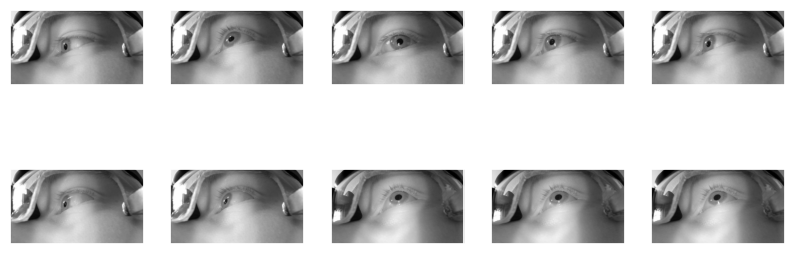

In [49]:
#code is from tensorflow website
#https://www.tensorflow.org/tutorials/images/cnn

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
plt.show()

In [50]:
#mean squared error for loss function

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(360, 640, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError,
             metrics=['accuracy'])
model.summary(line_length=80)

c:\Users\owend\miniconda3\envs\eyetracker\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                 │ (None, 358, 638, 32)     │           896 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)    │ (None, 179, 319, 32)     │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)                 │ (None, 177, 317, 64)     │        18,496 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)    │ (None, 88, 158, 64)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)                 │ (None, 86, 156, 64)      │        36,928 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)    │ (None, 43, 78, 64)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)                 │ (None, 41, 76, 128)      │        73,856 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)    │ (None, 20, 38, 128)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)                 │ (None, 18, 36, 128)      │       147,584 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)    │ (None, 9, 18, 128)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ flatten_1 (Flatten)               │ (None, 20736)            │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_2 (Dense)                   │ (None, 1024)             │    21,234,688 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_3 (Dense)                   │ (None, 4)                │         4,100 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 21,516,548 (82.08 MB)

 Trainable params: 21,516,548 (82.08 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                batch_size=10, epochs=20)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 614ms/step - accuracy: 0.3571 - loss: 0.0745 - val_accuracy: 0.2703 - val_loss: 0.0504
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 630ms/step - accuracy: 0.3941 - loss: 0.0482 - val_accuracy: 0.5676 - val_loss: 0.0501
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 628ms/step - accuracy: 0.4520 - loss: 0.0485 - val_accuracy: 0.2703 - val_loss: 0.0502
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 593ms/step - accuracy: 0.4130 - loss: 0.0486 - val_accuracy: 0.5676 - val_loss: 0.0501
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 587ms/step - accuracy: 0.4371 - loss: 0.0476 - val_accuracy: 0.5676 - val_loss: 0.0501
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 586ms/step - accuracy: 0.4665 - loss: 0.0487 - val_accuracy: 0.5676 - val_loss: 0.0501
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 592ms/step - accuracy: 0.4523 - loss: 0.0485 - val_accuracy: 0.2703 - val_loss: 0.0502
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 615ms/step - accuracy: 0.4768 - loss: 0.0484 - val_accu

[]

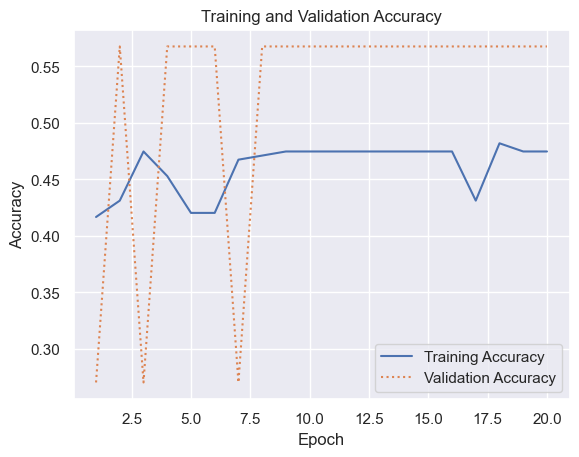

In [52]:
import seaborn as sns
sns.set()
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()